In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ntu-handwriting-digits/validation/7/number_7_bct_35.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_bct_134.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_ntl_63.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_httl_31.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_dkd_51.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_ntl_38.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_tqn_15.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_lxc_20.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_lxc_74.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_nnn_99.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_ntka_77.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_tdd_3.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_mttn_58.jpg
/kaggle/input/ntu-handwriting-digits/validation/7/number_7_lttn_18.jpg
/kaggle/input/nt

In [2]:
import os

import cv2
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

TRAIN_PATH = r'/kaggle/input/ntu-handwriting-digits/train'
TEST_PATH = r'/kaggle/input/ntu-handwriting-digits/test'
VALID_PATH = r'/kaggle/input/ntu-handwriting-digits/validation'

# **1. LOAD AND PREPROCESS IMAGE**

In [3]:
# load dataset
X_train = []; X_test = []; X_VALID = []
Y_train = []; Y_test = []; Y_VALID = []

for folder_number in os.listdir(TRAIN_PATH):
    for file_name in os.listdir(os.path.join(TRAIN_PATH,folder_number)):
        img = cv2.imread(os.path.join(TRAIN_PATH,folder_number,file_name),0)
        if img is None:
            continue
        X_train.append(img)
        Y_train.append(folder_number)
X_train = np.array(X_train,dtype=object)
Y_train = np.array(Y_train,dtype=object)

for folder_number in os.listdir(TEST_PATH):
    for file_name in os.listdir(os.path.join(TEST_PATH,folder_number)):
        img = cv2.imread(os.path.join(TEST_PATH,folder_number,file_name),0)
        X_test.append(img)
        Y_test.append(folder_number)
X_test = np.array(X_test,dtype=object)
Y_test = np.array(Y_test,dtype=object)

for folder_number in os.listdir(VALID_PATH):
    for file_name in os.listdir(os.path.join(VALID_PATH,folder_number)):
        img = cv2.imread(os.path.join(VALID_PATH,folder_number,file_name),0)
        X_VALID.append(img)
        Y_VALID.append(folder_number)
X_VALID = np.array(X_VALID,dtype=object)
Y_VALID = np.array(Y_VALID,dtype=object)

In [4]:
#load mnist data
(X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = mnist.load_data()
X_VALID_mnist = X_test_mnist[:1000]
Y_VALID_mnist = Y_test_mnist[:1000]
X_test_mnist = X_test_mnist[1000:]
Y_test_mnist = Y_test_mnist[1000:]

X_train = np.concatenate((X_train,X_train_mnist))
Y_train = np.concatenate((Y_train,Y_train_mnist))
X_test = np.concatenate((X_test,X_test_mnist))
Y_test = np.concatenate((Y_test,Y_test_mnist))
X_VALID = np.concatenate((X_VALID,X_VALID_mnist))
Y_VALID = np.concatenate((Y_VALID,Y_VALID_mnist))

11490434/11490434 [==============================] - 1s 0us/step


In [5]:
#shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

s = np.arange(X_VALID.shape[0])
np.random.shuffle(s)
X_VALID = X_VALID[s]
Y_VALID = Y_VALID[s]

In [6]:
#preprocessing
x_train = X_train / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = X_test / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)
x_valid = X_VALID / 255.0
x_valid = x_valid.reshape(-1, 28, 28, 1)

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)
y_valid = to_categorical(Y_VALID)

# **2. CNN Model**

In [7]:
model = Sequential()

#model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         1

In [8]:
# With data augmentation to prevent overfitting
batch_size = 128

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.01,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# datagen.fit(X_train)
train_gen = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = datagen.flow(x_valid, y_valid, batch_size=batch_size)
test_gen = datagen.flow(x_test, y_test, batch_size=batch_size)

In [9]:
epochs = 100
train_steps = x_train.shape[0] // batch_size
valid_steps = x_valid.shape[0] // batch_size

es = EarlyStopping(
    monitor="val_acc",  # metrics to monitor
    patience=10,  # how many epochs before stop
    verbose=1,
    mode="max",  # we need the maximum accuracy.
    restore_best_weights=True,  #
)

rp = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.2,
    patience=3,
    verbose=1,
    mode="max",
    min_lr=0.00001,
)

In [10]:
# Fit the model
history = model.fit(train_gen,
                              epochs = epochs,
                              steps_per_epoch = train_steps,
                              validation_data = valid_gen,
                              validation_steps = valid_steps,
                             callbacks=[es, rp])

Epoch 1/100
515/515 [==============================] - 34s 46ms/step - loss: 0.1318 - accuracy: 0.9589 - val_loss: 0.4086 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 2/100
515/515 [==============================] - 21s 42ms/step - loss: 0.0553 - accuracy: 0.9827 - val_loss: 0.0992 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/100
515/515 [==============================] - 21s 40ms/step - loss: 0.0440 - accuracy: 0.9868 - val_loss: 0.0743 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 4/100
515/515 [==============================] - 22s 42ms/step - loss: 0.0389 - accuracy: 0.9883 - val_loss: 0.0617 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 5/100
515/515 [==============================] - 21s 41ms/step - loss: 0.0329 - accuracy: 0.9899 - val_loss: 0.0565 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 6/100
515/515 [==============================] - 21s 40ms/step - loss: 0.0331 - accuracy: 0.9896 - val_loss: 0.0312 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 7/100
515/515 [==============================]

In [14]:
score_train = model.evaluate(x_train.astype(float),y_train)
score_test = model.evaluate(x_test.astype(float), y_test)
print('score-train: ',score_train)
print('score-test: ',score_test)
print('score-train using gen: ',model.evaluate(train_gen))
print('score-test using gen: ',model.evaluate(test_gen))

359/359 [==============================] - 1s 4ms/step - loss: 0.1600 - accuracy: 0.9887
score-train:  [20.61417579650879, 0.9988791346549988]
score-test:  [0.159988671541214, 0.9886729717254639]
516/516 [==============================] - 19s 38ms/step - loss: 0.0698 - accuracy: 0.9972
score-train using gen:  [0.06981437653303146, 0.9972432255744934]
90/90 [==============================] - 3s 37ms/step - loss: 0.4180 - accuracy: 0.9810
score-test using gen:  [0.4179997742176056, 0.9810054898262024]


In [16]:
y_pre = model.predict(x_test.astype(float))

359/359 [==============================] - 1s 3ms/step


In [17]:
np.sum(np.argmax(y_pre,axis=1) == np.argmax(y_test,axis=1))/y_test.shape[0]

0.9886729981702536

# **3. Evaluate the model**
***3.1 Training and validation curves***

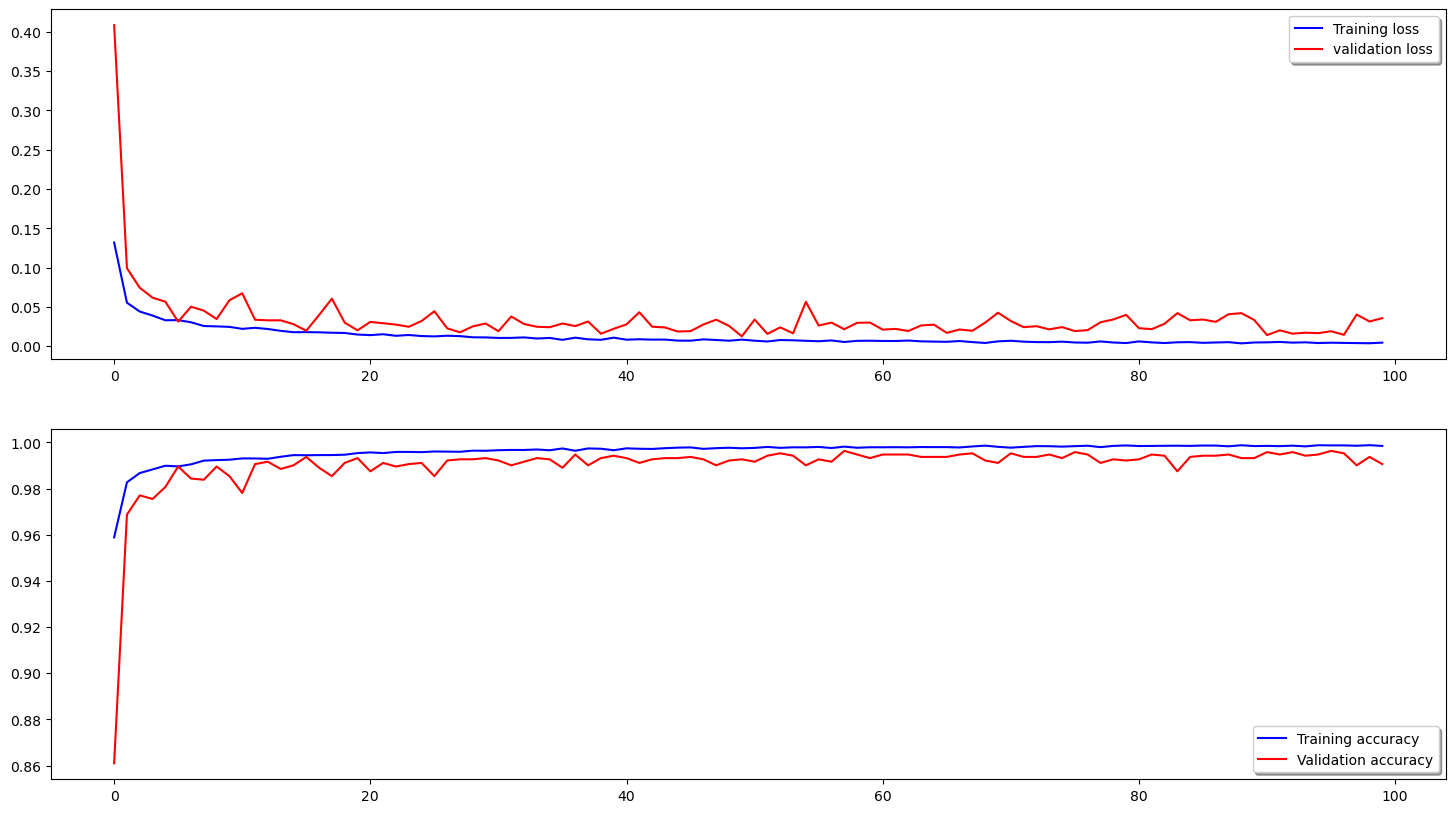

In [18]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

***3.2 Confusion matrix***

359/359 [==============================] - 1s 2ms/step


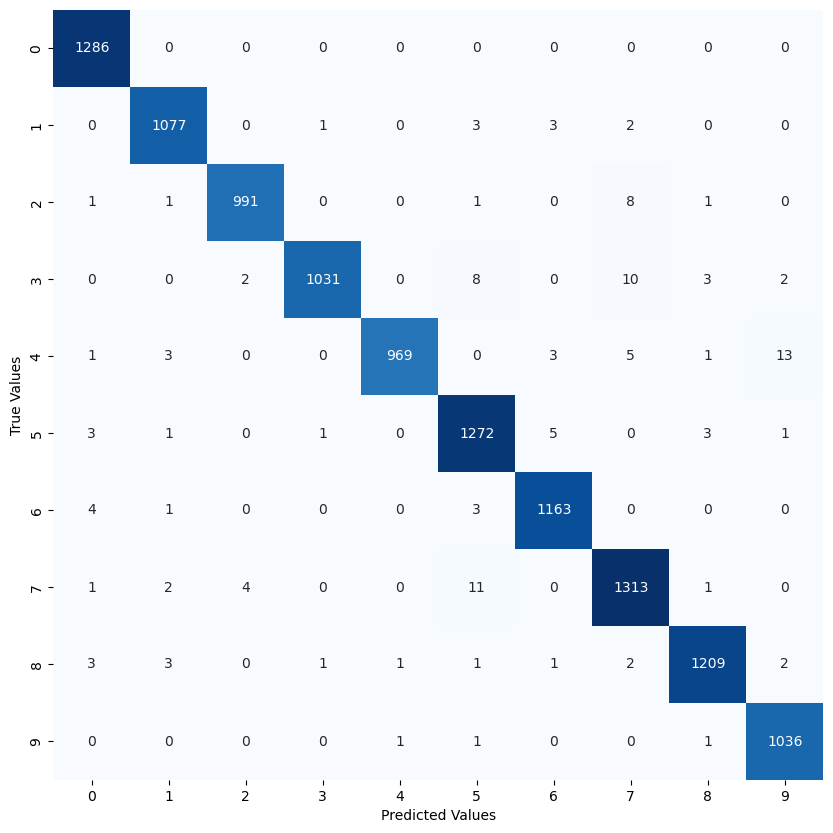

In [20]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(x_test.astype(float)) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

# **4. Prediction and submition**

***4.1 Prediction validation results***

359/359 [==============================] - 1s 2ms/step


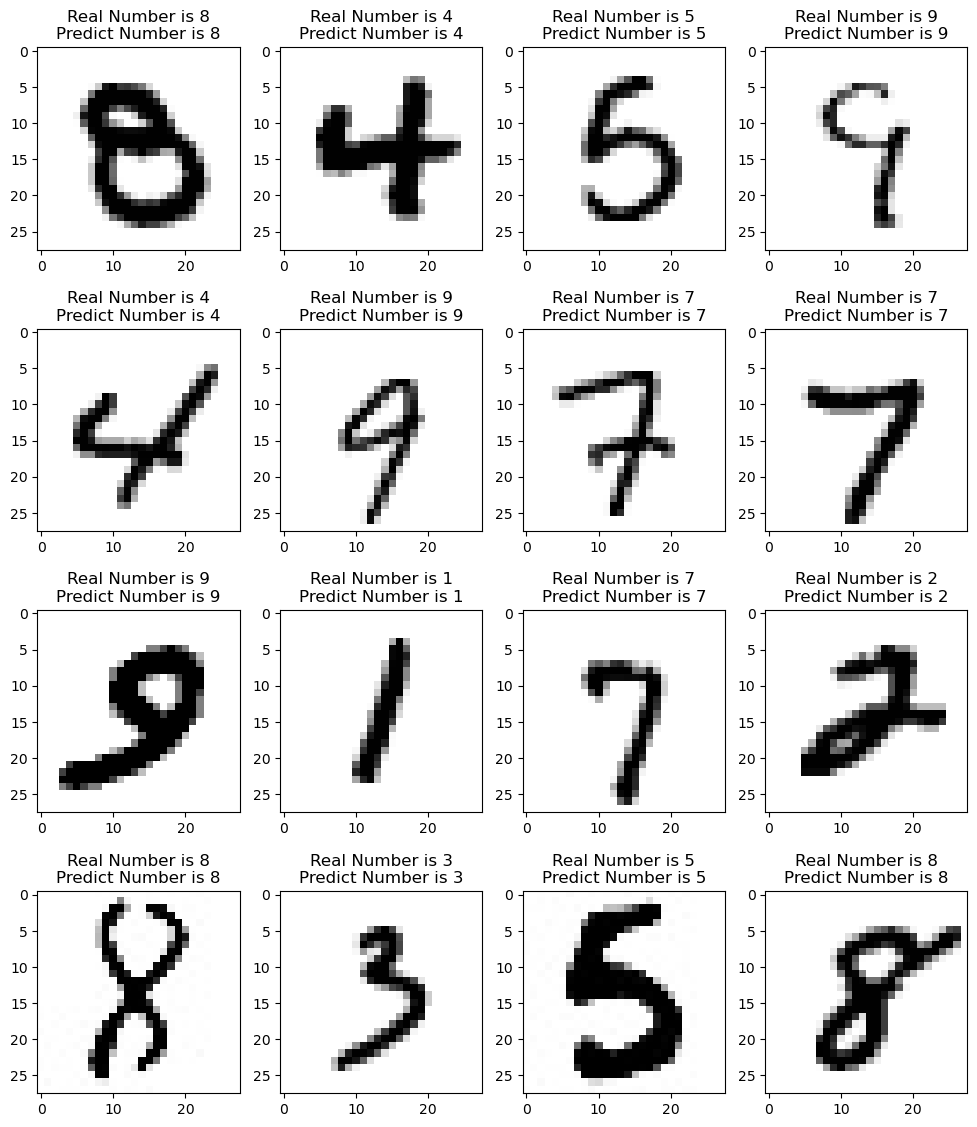

In [25]:
y_pred = model.predict(x_test.astype(float))
X_test__ = X_test.reshape(X_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i].astype(int), cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}");

***4.2 Submition***

In [27]:
# Evaluate the model
score = model.evaluate(x_test.astype(float),y_test)
print(score)

359/359 [==============================] - 1s 3ms/step - loss: 0.1600 - accuracy: 0.9887
[0.159988671541214, 0.9886729717254639]


In [28]:
import pickle

# Lưu mô hình ở định dạng h5
model.save('v1_ntu_handwriting_digits.h5')

# Lưu mô hình ở định dạng hdf5
model.save_weights('v1_ntu_handwriting_digits.hdf5')

# Lưu mô hình ở định dạng pkl
pickle.dump(model, open('v1_ntu_handwriting_digits.pkl', 'wb'))